In [107]:
from pathlib import Path
import pickle
from typing import Literal, Any
from dataclasses import dataclass

import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from tqdm.auto import tqdm
from scipy.special import log_softmax, expit
import IPython.display
import matplotlib.pyplot as plt

from spectrogram_transformer import AudioSpectrogramTransformer

In [2]:
dataset = load_dataset('yodas2_ru000_32k', split='train').take(100)

Resolving data files:   0%|          | 0/32401 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
class YodasSearcher:
    def __init__(
        self,
        dataset: Dataset,
        cache_file: str | Path,
    ):
        self.dataset = dataset

        cache_file = Path(cache_file)
        cache_file.parent.mkdir(exist_ok=True, parents=True)

        if cache_file.is_file():
            features = pickle.loads(cache_file.read_bytes())
        else:
            features = self.generate_features()
            cache_file.write_bytes(pickle.dumps(features))

        self.labels = AudioSpectrogramTransformer().labels
        
        self.features_df = pd.DataFrame(features)
    
    def get_features(self, sample: dict[str, Any]) -> dict[str, Any]:
        """Get searchable features for a sample"""
        sample = sample.copy()
        reorder_speakers_inplace(sample)

        features = {}
        features['text'] = ' '.join(sample['utterances']['text'])
        features['duration'] = sample['duration']
        features['n_speakers'] = len(sample['speaker_durations'])

        speaker_durations = np.array(sample['speaker_durations'])
        speaker_ratios = speaker_durations / speaker_durations.sum()   # may have length 0
        speaker_durations = np.concatenate([speaker_durations, np.full(10, np.nan)])
        speaker_ratios = np.concatenate([speaker_ratios, np.full(10, np.nan)])
        speaker_mask = get_speakers_mask(sample, tick_len=(tick_len := 1 / 100))

        for i in range(3):
            features[f'speaker{i}_duration'] = speaker_durations[i]
            features[f'speaker{i}_ratio'] = speaker_ratios[i]
        # simultaneous and total speech duration
        features['sim_speech_duration'] = (speaker_mask.sum(axis=0) > 1).sum() * tick_len
        features['speech_duration'] = (
            speaker_mask.max(axis=0).sum() * tick_len
            if len(speaker_mask) > 0 else 0
        )

        # using sigmoid for multilabel classification (not softmax),
        # according to the AST paper https://arxiv.org/abs/2104.01778
        ast_log_proba = expit(np.array(sample['ast'], dtype=np.float16))

        return features
    
    def generate_features(self) -> list[dict[str, bool | str | int | float]]:
        """Returns dict of searchable features (with "video_id" field) for each sample in self.dataset"""
        return [
            {'video_id': sample['video_id'], **self.get_features(sample)}
            for sample in self.dataset
        ]
    
    def search(
        self,
        text_query: str = '',
        mode: Literal['and', 'or'] = 'and',
        features_query: str = '',
    ) -> pd.DataFrame:
        if text_query != '':
            mask_found_by_text_query = self.features_df['text'].str.contains(text_query, case=False, regex=False)
            loc_found_by_text_query = self.features_df.index[mask_found_by_text_query].tolist()
        else:
            loc_found_by_text_query = []
        
        if features_query != '':
            loc_found_by_feature_query = self.features_df.query(features_query).index.tolist()
        else:
            loc_found_by_feature_query = []
        
        fn = {'and': set.intersection, 'or': set.union}[mode]
        loc_found = list(fn(
            set(loc_found_by_text_query),
            set(loc_found_by_feature_query)
        ))

        return self.features_df.loc[loc_found]

    def display(
        self,
        df: pd.DataFrame,
    ):
        df = df.assign(text=lambda df: df.text.str.slice(0, 200)) #.str.wrap(50)
        style = df.style.format(precision=1)

        width = {'video_id': 100, 'text': 300}

        for col_name in df.columns:
            style.set_table_styles({
                col_name: [
                    {
                        'selector': 'td, th',
                        'props': [
                            ('text-align', 'center'),
                            ('padding', '0em 0em'),
                            ('border', '1px solid grey !important'),
                        ],
                    },
                    {
                        'selector': 'td',
                        'props': [
                            ('max-width', f'{width.get(col_name, 40)}px'),
                            ('width', f'{width.get(col_name, 40)}px'),
                        ],
                    },
                    {
                        'selector': 'th',
                        'props': [
                            # ('max-width', f'{width.get(col_name, 40)}px'),
                            ('max-width', '0px'),
                            ('height', '170px'),
                            ('transform', 'translateY(4em) rotate(-90deg);'),
                        ],
                    },
                ]
            }, overwrite=False)

        IPython.display.display(style)

seacher = YodasSearcher(dataset, 'cache.pkl')

In [78]:
result = seacher.search('привет', 'and', 'duration < 500')
seacher.display(result)

,video_id,duration,text,n_speakers,speaker0_duration,speaker0_ratio,speaker1_duration,speaker1_ratio,speaker2_duration,speaker2_ratio,sim_speech_duration,speech_duration
0,YoSwHP0w-so,51.9,Привет друзья и с вами снова Жека у себя на балконе и Давайте опять послушаем короткие анекдот от меня да да друзья вам не послышалось именно от меня от вашего Джеки Поэтому заранее ставим такой вот ж,3,44.3,0.9,2.2,0.0,1.6,0.0,0.1,48.0
34,YrX29aGhFlY,356.8,"Привет друзья и гости нашего канала! С вами канал ""Мужская Кухня""! Сегодня на кухне я и товарищ Кот! Сегодня буду готовить щи по литовски с капустой! Мой вариант щи назвал ""ШОПОПАЛО""! Название придума",1,203.1,1.0,nan,nan,nan,nan,0.1,203.8
7,Y18nT1gQQTk,281.7,"- Привет, НЕМИРКИНЫ. Говорят, что одиночество - это универсальный человеческий опыт. И есть шанс, что если вы смотрите эту передачу, то, скорее всего, вы тоже чувствовали себя одиноким. Никто не свобо",1,265.2,1.0,nan,nan,nan,nan,0.1,265.8
40,YtmZAbpfPJY,403.7,Приятного просмотра! Как у вас дела? Знание местного приветствия Знание новой техники массажа Да Зачать ребенка Вы Даа Зачать ребенка Да Постучать по груди Ого что ??? Да Энергичность Неутомимость Все,2,46.5,0.6,34.7,0.4,nan,nan,0.1,78.0
73,YBocVEO7Cd0,356.9,"- Привет, добро пожаловать. Во всем мире наблюдается огромный спад психического здоровья, поэтому мы стремимся создавать больше контента, чем когда-либо. спасибо большое что стали частью нашего путеше",1,338.0,1.0,nan,nan,nan,nan,0.1,338.7
13,Y4YGI59SkmA,132.5,"Дорогие друзья, рады приветствовать! С вами Инвестиционный центр Павловы и Партнеры. В наших видео мы отвечаем на вопросы подписчиков о торгах и аукционах по банкротству. Обратите внимание, если еще н",1,115.4,1.0,nan,nan,nan,nan,0.1,115.8
20,Y78t8PweBAM,382.9,"У него запах еды из центральной Азии. Макароны в Бразилии, они же и овощи тоже! Расскажу вам секрет. Если вы хотите разбить русское девичье сердце... Еда! Бразильская еда! Бразильская еда!... Привет,",2,362.1,1.0,1.5,0.0,nan,nan,0.1,362.4
87,YFuHO7q4JQu,220.2,Всем Привет Дорогие Друзья Меня Зовут Миссоури И в этом видео-ролики я очу вам показать мод на паразитов Который был импортирован из Java Версии То есть это копия оригинального дополнения Ссылка на до,1,216.3,1.0,nan,nan,nan,nan,0.1,216.3
23,Y8w8_IuXr8u,283.0,привет привет дорогие друзья добро пожаловать на мой канал видео завораживающие русский где мы говорим о самых длинных интересных необычных словах русского языка сразу сейчас ставьте лайк лайк лайк по,1,211.0,1.0,nan,nan,nan,nan,0.1,211.9
58,YyYZbNKUttQ,78.2,"Всем привет! С Вами мой друг ПАНДА. Он Вам расскажет сочинение, стихотворение собственного сочинения. Оно коротенькое, но интересное. Поехали! Льются ливни, слёзы тушат! Пламя из сердца вышло наружу!",2,46.7,0.8,9.5,0.2,nan,nan,0.1,56.5


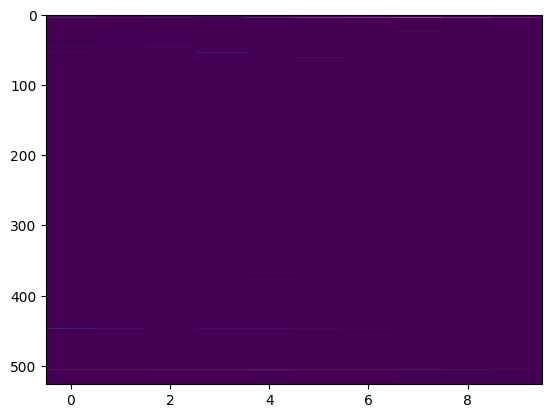

In [ ]:
sample = dataset[1]
ast_log_proba = expit(np.array(sample['ast'], dtype=np.float16))
plt.imshow(ast_log_proba.T, aspect='auto', interpolation='none')

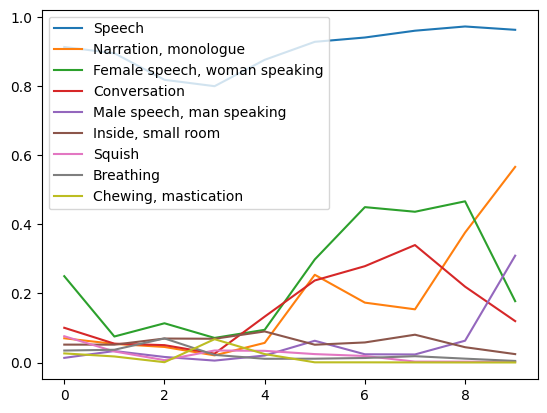

In [114]:
max_probas = ast_log_proba.max(axis=0)
count = min((max_probas > -5).sum(), 10)
indices = np.argsort(max_probas)[:-count:-1]

for class_idx in indices:
    plt.plot(ast_log_proba[:, class_idx], label=seacher.labels[class_idx])
plt.legend();

In [115]:
IPython.display.Audio(f'yodas2_ru000_32k/{sample["audio"]["path"]}')